# Face Recognition using Inception Model

In [59]:
from keras.models import Sequential
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras.engine.topology import Layer
from keras import backend as K
K.set_image_data_format('channels_first')
import cv2
import os
import numpy as np
from numpy import genfromtxt
import pandas as pd
import tensorflow as tf
from face_recognition import *
from inception_blocks_v2 import *
from matplotlib.pyplot import imshow
import scipy.io
import scipy.misc

%matplotlib inline
%load_ext autoreload
%autoreload 2

np.set_printoptions(threshold=np.nan)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
# Triplet loss

def triplet_loss(y_true, y_pred, alpha = 0.2):
       
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
    
    # Compute the (encoding) distance between the anchor and the positive
    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, positive)), axis = -1)
    # Compute the (encoding) distance between the anchor and the negative
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, negative)), axis = -1)
    # Subtract the two previous distances and add alpha.
    basic_loss = tf.add(tf.subtract(pos_dist, neg_dist), alpha)
    # Take the maximum of basic_loss and 0.0. Sum over the training examples.
    loss = tf.reduce_sum(tf.maximum(basic_loss, 0))
    
    return loss

In [61]:
#creating a model for face recognition of images
FRmodel = faceRecoModel(input_shape=(3, 96, 96))
print("Total Params:", FRmodel.count_params())

Total Params: 3743280


In [62]:
# We load a previously trained model

FRmodel.compile(optimizer = 'adam', loss = triplet_loss, metrics = ['accuracy'])
load_weights_from_FaceNet(FRmodel)

In [63]:
database = {}
database["harry"] = img_to_encoding("images/harry_0.jpg", FRmodel)
database["ron"] = img_to_encoding("images/ron.jpg", FRmodel)
database["hermione"] = img_to_encoding("images/hermione.jpg", FRmodel)
database["snape"] = img_to_encoding("images/snape.jpg", FRmodel)
database["sirius"] = img_to_encoding("images/sirius.jpg", FRmodel)
database["draco"] = img_to_encoding("images/draco.jpg", FRmodel)
database["dumbledore"] = img_to_encoding("images/dumbledore.jpg", FRmodel)

# Face Verification

Verify if two images belong to the same person

In [64]:
# function to verify whether an image is similar to any image in the database
def verify(image_path, identity, database, model):
    
    
    #Compute the encoding for the image
    encoding = img_to_encoding(image_path, model)
    
    #Compute distance with identity's image
    dist = np.linalg.norm((database[identity] - encoding))
    
    # "Welcome if dist < 0.7, else dont
    if dist < 0.7:
        print("It's " + str(identity) + ", welcome!")
        door_open = True
    else:
        print("It's not " + str(identity) + ", please go away")
        door_open = False
        
    return dist, door_open

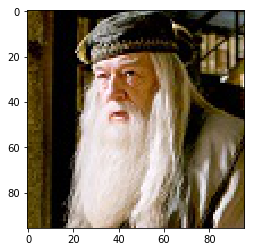

In [65]:
#verifying if aberforth could be mistaken as dumbledore
iden_image = scipy.misc.imread("images/dumbledore.jpg")
imshow(iden_image)


It's not dumbledore, please go away


(0.87835985, False)

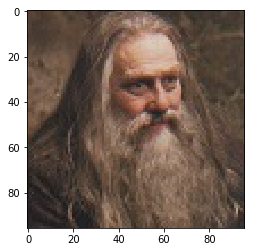

In [66]:
recog_image1 = scipy.misc.imread("images/aberforth.jpg")
imshow(recog_image1)
verify("images/aberforth.jpg", "dumbledore", database, FRmodel)

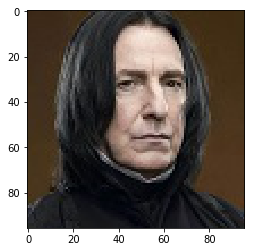

In [67]:
iden_image1 = scipy.misc.imread("images/snape.jpg")
imshow(iden_image1)

It's not snape, please go away


(0.8388325, False)

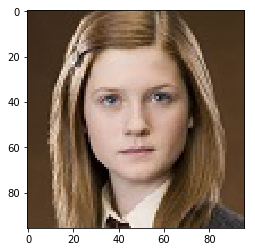

In [68]:
#verifying if ginny could be mistaken as snape

recog_image1 = scipy.misc.imread("images/ginny.jpg")
imshow(recog_image1)
verify("images/ginny.jpg", "snape", database, FRmodel)

# Face Recognition

Given a database of images recognise whom the input image belongs to.

In [69]:
def recognise(image_path, database, model):
    
    # Compute the target "encoding" for the image. 
    encoding = img_to_encoding(image_path, model)
    
    # Find the closest encoding    
    
    min_dist = 100    
    
    for (name, db_enc) in database.items():
        
        # Compute L2 distance between the target encoding and the current emb 
        dist = np.linalg.norm((encoding-db_enc))
    
        if dist < min_dist:
            min_dist = dist
            identity = name

    
    if min_dist > 0.75:
        print("Image not recognised!")
    else:
        print ("it's " + str(identity) + ", the distance is " + str(min_dist))
        
    return min_dist, identity

Image not recognised!


(0.76052016, 'hermione')

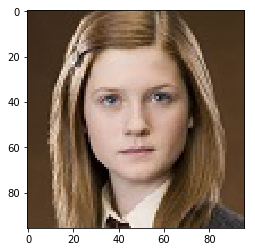

In [70]:
recog_image = scipy.misc.imread("images/ginny.jpg")
imshow(recog_image)
recognise("images/ginny.jpg", database, FRmodel)

it's hermione, the distance is 0.7334566


(0.7334566, 'hermione')

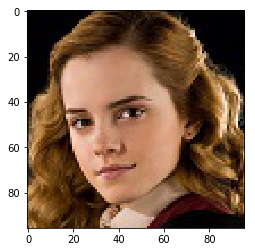

In [71]:
recog_image = scipy.misc.imread("images/hermione_1.jpg")
imshow(recog_image)
recognise("images/hermione_1.jpg", database, FRmodel)